## Librerias

In [9]:
# Tratamiento de datos
# ============================================================================
import pandas as pd
import numpy as np
import datetime

# Gráficos
# ============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5

# Modelado y Forescasting
# ============================================================================
from lightgbm import LGBMRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

# Configuración de warnings
# ============================================================================
import warnings
warnings.filterwarnings('ignore')


## Exploracion de datos

In [10]:
url = 'https://raw.githubusercontent.com/ronalcabrera/PG_Olist/main/Semana2/Datasets_procesados/'

sellers = pd.read_csv(url+'sellers.csv')

products = pd.read_csv(url+'products.csv')

orders = pd.read_csv(url+'orders.csv')
orders.order_purchase_timestamp=pd.to_datetime(orders.order_purchase_timestamp, format='%Y-%m-%dT')
orders.order_delivered_customer_date=pd.to_datetime(orders.order_delivered_customer_date, format='%Y-%m-%dT')
orders.order_estimated_delivery_date=pd.to_datetime(orders.order_estimated_delivery_date, format='%Y-%m-%dT')
orders['tiempo_trans_total'] = (orders.order_delivered_customer_date - orders.order_purchase_timestamp).dt.days
orders['tiempo_demora'] = (orders.order_delivered_customer_date - orders.order_estimated_delivery_date).dt.days
#orders.order_purchase_timestamp=orders.order_purchase_timestamp.dt.date

order_items = pd.read_csv(url+'order_items.csv')
order_items['price_total'] = order_items['price'].values + order_items['freight_value'].values

order_reviews = pd.read_csv(url+'order_reviews.csv')

order_payments = pd.read_csv(url+'order_payments.csv')
closed_deals = pd.read_csv(url+'closed_deals.csv')
customers = pd.read_csv(url+'customers.csv')
marketing_qualified_leads = pd.read_csv(url+'marketing_qualified_leads.csv')
zip_code_prefix = pd.read_csv(url+'zip_code_prefix.csv')

df= orders[['id_order','id_customer','order_purchase_timestamp','order_status','tiempo_trans_total','tiempo_demora']].merge(
    order_items[['id_order','id_product','id_seller','price_total']], how='left').merge(
    sellers[['id_seller','id_code_prefix']], how='left').merge(
    products[['id_product','product_name_lenght','product_description_lenght','product_photos_qty','product_weight_g','product_length_cm','product_height_cm','product_width_cm']], how='left').merge(
    order_reviews[['id_order','review_score']], how='left').merge(
    customers[['id_customer','id_code_prefix']], how='left')

# Tomo los datos que voy a usar, agrego cantidad ventas. VENTAS/Año: 2016= 366 ventas / 2017 = 49876 ventas / 2018 = 60531 ventas
datos = df[['id_order','order_purchase_timestamp']].groupby(
            ['order_purchase_timestamp']).count()

# Agrego cantidad de ventas
datos.rename(columns={'id_order':'cantidad_ventas'}, inplace=True)

# Armo el dataframe en intervalos de a 1 hora
datos = datos.resample(rule='H', closed='left', label='right').sum()

# Creo variable que indica si es fin de semana
datos['dia_semana'] = datos.index.dayofweek
datos = pd.get_dummies(datos, columns=['dia_semana'])
datos = datos.fillna(0)

# Agrego columna vacaciones para los dias festivos inamobibles: https://www.datosmundial.com/america/brasil/dias-festivos.php
datos['holidays']=  np.where((datos.reset_index()['order_purchase_timestamp'].dt.month==1)&(datos.reset_index()['order_purchase_timestamp'].dt.day==20),1,
                    np.where((datos.reset_index()['order_purchase_timestamp'].dt.month==1)&(datos.reset_index()['order_purchase_timestamp'].dt.day==1),1,
                    np.where((datos.reset_index()['order_purchase_timestamp'].dt.month==1)&(datos.reset_index()['order_purchase_timestamp'].dt.day==25),1,
                    np.where((datos.reset_index()['order_purchase_timestamp'].dt.month==4)&(datos.reset_index()['order_purchase_timestamp'].dt.day==21),1,
                    np.where((datos.reset_index()['order_purchase_timestamp'].dt.month==4)&(datos.reset_index()['order_purchase_timestamp'].dt.day==23),1,
                    np.where((datos.reset_index()['order_purchase_timestamp'].dt.month==5)&(datos.reset_index()['order_purchase_timestamp'].dt.day==1),1,
                    np.where((datos.reset_index()['order_purchase_timestamp'].dt.month==6)&(datos.reset_index()['order_purchase_timestamp'].dt.day==12),1,
                    np.where((datos.reset_index()['order_purchase_timestamp'].dt.month==7)&(datos.reset_index()['order_purchase_timestamp'].dt.day==9),1,
                    np.where((datos.reset_index()['order_purchase_timestamp'].dt.month==8)&(datos.reset_index()['order_purchase_timestamp'].dt.day==15),1,
                    np.where((datos.reset_index()['order_purchase_timestamp'].dt.month==8)&(datos.reset_index()['order_purchase_timestamp'].dt.day==28),1,
                    np.where((datos.reset_index()['order_purchase_timestamp'].dt.month==9)&(datos.reset_index()['order_purchase_timestamp'].dt.day==7),1,
                    np.where((datos.reset_index()['order_purchase_timestamp'].dt.month==10)&(datos.reset_index()['order_purchase_timestamp'].dt.day==12),1,
                    np.where((datos.reset_index()['order_purchase_timestamp'].dt.month==10)&(datos.reset_index()['order_purchase_timestamp'].dt.day==15),1,
                    np.where((datos.reset_index()['order_purchase_timestamp'].dt.month==10)&(datos.reset_index()['order_purchase_timestamp'].dt.day==28),1,
                    np.where((datos.reset_index()['order_purchase_timestamp'].dt.month==11)&(datos.reset_index()['order_purchase_timestamp'].dt.day==2),1,
                    np.where((datos.reset_index()['order_purchase_timestamp'].dt.month==11)&(datos.reset_index()['order_purchase_timestamp'].dt.day==15),1,
                    np.where((datos.reset_index()['order_purchase_timestamp'].dt.month==11)&(datos.reset_index()['order_purchase_timestamp'].dt.day==20),1,
                    np.where((datos.reset_index()['order_purchase_timestamp'].dt.month==12)&(datos.reset_index()['order_purchase_timestamp'].dt.day==24),1,
                    np.where((datos.reset_index()['order_purchase_timestamp'].dt.month==12)&(datos.reset_index()['order_purchase_timestamp'].dt.day==25),1,
                    np.where((datos.reset_index()['order_purchase_timestamp'].dt.month==12)&(datos.reset_index()['order_purchase_timestamp'].dt.day==26),1,
                    np.where((datos.reset_index()['order_purchase_timestamp'].dt.month==12)&(datos.reset_index()['order_purchase_timestamp'].dt.day==31),1,
                    0)))))))))))))))))))))

In [11]:
# Separo los datos entrenamiento - validacion - test
# ============================================================================
fin_train = '2018-03-31 23:00:00' 
fin_validacion = '2018-06-30 23:00:00'
#fin_test = '2018-08-31 23:00:00' # No se toma en cuenta Septiembre por inconsistencias en los datos.

datos_train = datos.loc[:fin_train,:] # 19 meses
datos_val = datos.loc[fin_train:fin_validacion,:] # 3 meses
datos_test = datos.loc[fin_validacion:,:] # 2 meses

print(f"Fechas train        : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas validación   : {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")
print(f"Fechas test         : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

Fechas train        : 2016-09-04 22:00:00 --- 2018-03-31 23:00:00  (n=13754)
Fechas validación   : 2018-03-31 23:00:00 --- 2018-06-30 23:00:00  (n=2185)
Fechas test         : 2018-06-30 23:00:00 --- 2018-10-17 18:00:00  (n=2612)


## Exploración gráfica

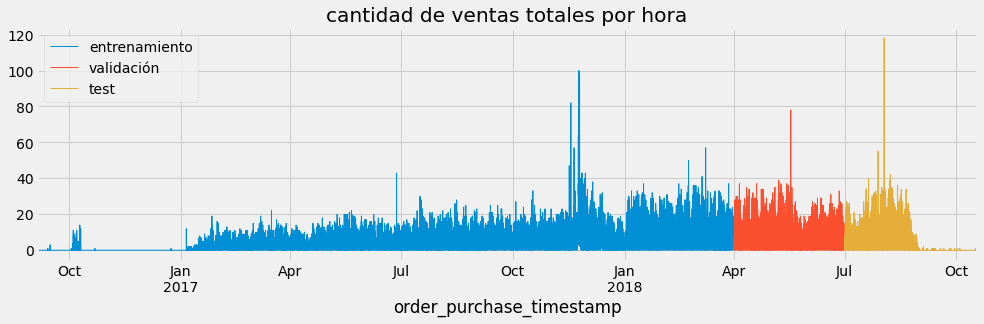

In [12]:
# Gráfica de la serie temporal
# ============================================================================
fig, ax = plt.subplots(figsize=(15,4))
datos_train.cantidad_ventas.plot(ax=ax, label='entrenamiento', linewidth=1)
datos_val.cantidad_ventas.plot(ax=ax, label='validación', linewidth=1)
datos_test.cantidad_ventas.plot(ax=ax, label='test', linewidth=1)
ax.set_title('cantidad de ventas totales por hora')
ax.legend();

In [13]:
# Gráfica interactivo de la serie temporal
# ============================================================================
datos.loc[:fin_train, 'partition'] = 'train'
datos.loc[fin_train:fin_validacion, 'partition'] = 'validation'
datos.loc[fin_validacion:, 'partition'] = 'test'

fig = px.line(
    data_frame  = datos.reset_index(),
    x           = 'order_purchase_timestamp',
    y           = 'cantidad_ventas',
    color       = 'partition',
    title       = 'Numero de ventas totales',
    width       = 1200,
    height      = 580
)
fig.show()
datos=datos.drop(columns='partition')

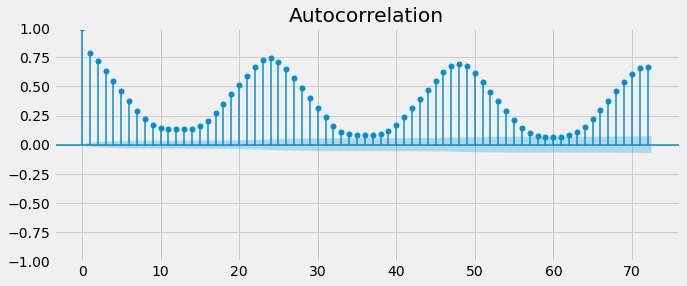

In [14]:
# Gráfica de autocorrelación
# ============================================================================
fig, ax = plt.subplots(figsize=(10,4))
plot_acf(datos.cantidad_ventas, ax=ax, lags=72)
plt.show()

Podemos observar en el gráfico que hay una directa correlación entre lo que pasa un día respecto a lo que pasó el día anterior a la misma hora

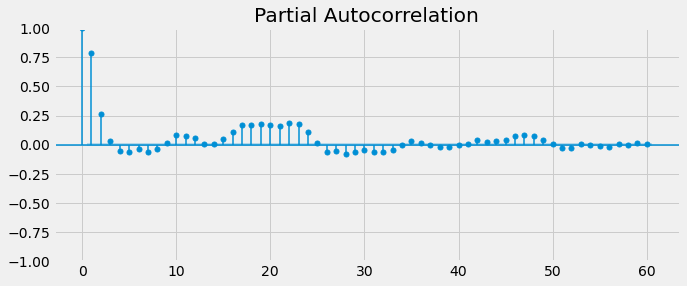

In [15]:
# Gráfica de autocorrelación parcial
# ============================================================================
fig, ax = plt.subplots(figsize=(10,4))
plot_pacf(datos.cantidad_ventas, ax=ax, lags=60)
plt.show()

Text(0, 0.5, 'Festivo')

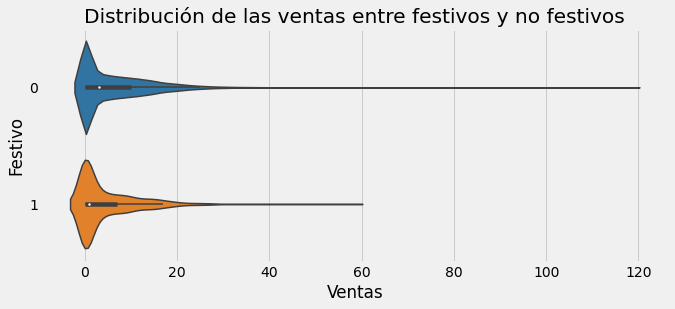

In [16]:
# Días festivos vs laborales
# ============================================================================
fig, ax = plt.subplots(figsize=(10,4))
sns.violinplot(
    x       = 'cantidad_ventas',
    y       = 'holidays',
    data    = datos.assign(holidays=datos.holidays.astype(str)),
    palette = 'tab10',
    ax      = ax
)
ax.set_title('Distribución de las ventas entre festivos y no festivos')
ax.set_xlabel('Ventas')
ax.set_ylabel('Festivo')

Se observa un mayor volumen de ventas en los días no festivos

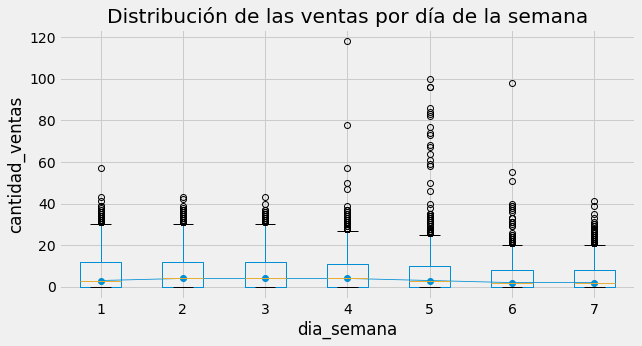

In [17]:
# Gráfico boxplot para estacionalidad semanal
# ============================================================================
fig, ax = plt.subplots(figsize=(10,5))
datos['dia_semana']=datos.index.day_of_week + 1
datos.boxplot(column='cantidad_ventas', by='dia_semana', ax=ax)
datos.groupby('dia_semana')['cantidad_ventas'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('cantidad_ventas')
ax.set_title('Distribución de las ventas por día de la semana')
fig.suptitle('');

Las ventas se distribuyen de forma equitativa a lo largo de la semana, no hay ninguna diferencia apreciable en cuanto a ello.

## Modelado

In [18]:
# Creo y entreno forecaster
# ============================================================================
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(max_depth=2, learning_rate=0.1, n_estimators=50),
                lags      = 24
            )
forecaster


ForecasterAutoreg 
Regressor: LGBMRegressor(max_depth=2, n_estimators=50) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 2, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 50, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Creation date: 2023-01-31 17:55:22 
Last fit date: None 
Skforecast version: 0.6.0 
Python version: 3.10.8 

In [19]:
# Entreno el modelo
# ============================================================================
forecaster.fit(y=datos.loc[:fin_validacion, 'cantidad_ventas']) # Entrenamiento con conjuntos de train y validación
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(max_depth=2, n_estimators=50) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2016-09-04 22:00:00'), Timestamp('2018-06-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 2, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 50, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Creation date: 2023-01-31 17:55:22 
Last fi

## Predicción

In [20]:
predicciones = forecaster.predict(steps=24)
predicciones

2018-07-01 00:00:00     9.162073
2018-07-01 01:00:00     5.650966
2018-07-01 02:00:00     3.306472
2018-07-01 03:00:00     1.237291
2018-07-01 04:00:00     0.632996
2018-07-01 05:00:00     0.179540
2018-07-01 06:00:00     0.370554
2018-07-01 07:00:00     0.512076
2018-07-01 08:00:00     1.508327
2018-07-01 09:00:00     3.668042
2018-07-01 10:00:00     7.475074
2018-07-01 11:00:00     8.479153
2018-07-01 12:00:00     7.809290
2018-07-01 13:00:00     8.825860
2018-07-01 14:00:00     7.857089
2018-07-01 15:00:00     8.284839
2018-07-01 16:00:00     7.506628
2018-07-01 17:00:00     8.948859
2018-07-01 18:00:00     8.271376
2018-07-01 19:00:00     8.055861
2018-07-01 20:00:00     8.576523
2018-07-01 21:00:00    10.390391
2018-07-01 22:00:00     9.993338
2018-07-01 23:00:00     9.002374
Freq: H, Name: pred, dtype: float64

In [21]:
# Plot de predicciones interactivas
# ============================================================================
datos_plot = pd.DataFrame({
                'test': datos_test['cantidad_ventas'],
                'prediction': predicciones,
            })
datos_plot.index.name= 'order_purchase_timestamp'

fig = px.line(
    data_frame  = datos_plot.reset_index(),
    x           = 'order_purchase_timestamp',
    y           = datos_plot.columns,
    title       = 'Ventas totales',
    width       = 1200,
    height      = 500
)

fig.update_xaxes(rangeslider_visible=True)
fig.show()

## Backtesting

In [22]:
# Backtest
# ============================================================================
metrica, predicciones = backtesting_forecaster(
                                forecaster=forecaster,
                                y=datos['cantidad_ventas'],
                                initial_train_size=len(datos.loc[:fin_validacion]),
                                steps=24,
                                metric='mean_absolute_error',
                                refit=False,
                                verbose=False
)

In [23]:
print(f'Backtest error: {metrica}')

Backtest error: 2.198317916195435


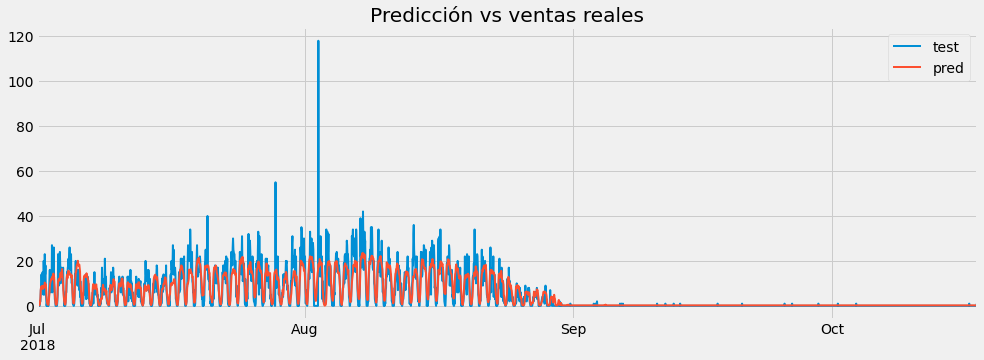

In [24]:
# Gráfico
# ============================================================================
fig, ax = plt.subplots(figsize=(15,5))
datos.loc[predicciones.index, 'cantidad_ventas'].plot(ax=ax, linewidth=2, label='test')
predicciones.plot(linewidth=2, label='prediccion', ax=ax)
ax.set_title('Predicción vs ventas reales')
ax.legend();

In [25]:
# Plot de predicciones interactivas
# ============================================================================
datos_plot=pd.DataFrame({
                'test': datos_test['cantidad_ventas'],
                'prediction': predicciones['pred'],
})
datos_plot.index.name='order_purchase_timestamp'

fig = px.line(
    data_frame  = datos_plot.reset_index(),
    x           = 'order_purchase_timestamp',
    y           = datos_plot.columns,
    title       = 'Ventas totales',
    width       = 1200,
    height      = 500
)

fig.update_xaxes(rangeslider_visible=True)
fig.show()

## Optimizacion de parámetros

In [26]:
# Grid_search de hiperparámetros
# ============================================================================
# Hiperparámetros del regresor
param_grid = {
    'max_iter': [100, 500],
    'max_depth': [3, 10],
    'learning_rate': [0.01, 0.1]
}
# Lags utulizados como predictores
lags_grid = [24, 48, [1, 2, 24]]

resultados_grid = grid_search_forecaster(
                    forecaster          = forecaster,
                    y                   = datos.loc[:fin_validacion, 'cantidad_ventas'], # conjunto de train y validacion
                    param_grid          = param_grid,
                    lags_grid           = lags_grid,
                    steps               = 24,
                    refit               = False,
                    metric              = 'mean_absolute_error',
                    initial_train_size  = int(len(datos_train)), # El modelo se entrena con los datos de entrenamiento
                    return_best         = True,
                    verbose             = False
                )

Number of models compared: 24.


loop lags_grid:   0%|                                               | 0/3 [00:00<?, ?it/s]

[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100


[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500


[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100


[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500


[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100


[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500


[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100


[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500


loop lags_grid:  33%|█████████████                          | 1/3 [00:03<00:07,  3.60s/it]

[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100


[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500


[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100


[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500


[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100


[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500


[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100


[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500


loop lags_grid:  67%|██████████████████████████             | 2/3 [00:07<00:03,  3.96s/it]

[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100


[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500


[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100


[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500


[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100


[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500


[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100


[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:10<00:00,  3.65s/it]


[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 10, 'max_iter': 500}
  Backtesting metric: 3.6088803697676592



In [27]:
# Resultados de grid_search
# ============================================================================
resultados_grid.head(10)

,lags,params,mean_absolute_error,learning_rate,max_depth,max_iter
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 10, 'max_...",3.608880,0.01,10.0,500.0
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'max_it...",3.624746,0.10,3.0,500.0
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'max_i...",3.659089,0.10,10.0,100.0
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'max_it...",3.679697,0.10,3.0,100.0
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'max_i...",3.681370,0.10,10.0,500.0
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'max_i...",3.692238,0.10,10.0,100.0
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'max_it...",3.704508,0.10,3.0,500.0
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 10, 'max_...",3.713160,0.01,10.0,500.0
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'max_i...",3.740469,0.10,10.0,500.0
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 3, 'max_i...",3.744229,0.01,3.0,500.0


In [28]:
# Backtest con nuevos hiperparámetros
# ============================================================================
metrica, predicciones = backtesting_forecaster(
    forecaster          = forecaster,
    y                   = datos.cantidad_ventas,
    initial_train_size  = len(datos.loc[:fin_validacion]),
    steps               = 24,
    metric              = 'mean_absolute_error',
    refit               = False,
    verbose             = False
)
print(f'Backtest error: {metrica}')

[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500
Backtest error: 2.148337621217509


Ahora agrego otras variables , llamadas variables exógenas, para mejorar la predicción

In [29]:
# Backtest con nuevos hiperparámetros
# ============================================================================
forecaster = ForecasterAutoreg(
                regressor=LGBMRegressor(max_depth=10, learning_rate=0.01, n_estimators=500),
                lags=48
            )
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(learning_rate=0.01, max_depth=10, n_estimators=500) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
Transformer for y: None 
Transformer for exog: None 
Window size: 48 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.01, 'max_depth': 10, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Creation date: 

In [30]:
variables_exog = ['holidays','dia_semana_0','dia_semana_1','dia_semana_2',
                'dia_semana_3','dia_semana_4','dia_semana_5','dia_semana_6']
forecaster.fit(
    y=datos.loc[:fin_validacion, 'cantidad_ventas'],
    exog=datos.loc[:fin_validacion, variables_exog]
    )
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(learning_rate=0.01, max_depth=10, n_estimators=500) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
Transformer for y: None 
Transformer for exog: None 
Window size: 48 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['holidays', 'dia_semana_0', 'dia_semana_1', 'dia_semana_2', 'dia_semana_3', 'dia_semana_4', 'dia_semana_5', 'dia_semana_6'] 
Training range: [Timestamp('2016-09-04 22:00:00'), Timestamp('2018-06-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.01, 'max_depth': 10, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimato

In [31]:
# Predicción
# ============================================================================
exog_siguientes_24h = datos_test[variables_exog][:24]

predicciones = forecaster.predict(steps=24, exog=exog_siguientes_24h)
predicciones

2018-07-01 00:00:00     7.153507
2018-07-01 01:00:00     4.213122
2018-07-01 02:00:00     1.990696
2018-07-01 03:00:00     0.737786
2018-07-01 04:00:00     0.262533
2018-07-01 05:00:00     0.382860
2018-07-01 06:00:00     0.482506
2018-07-01 07:00:00     0.912514
2018-07-01 08:00:00     2.477870
2018-07-01 09:00:00     3.985376
2018-07-01 10:00:00     6.990181
2018-07-01 11:00:00     8.711423
2018-07-01 12:00:00     8.701044
2018-07-01 13:00:00     9.352098
2018-07-01 14:00:00     8.451254
2018-07-01 15:00:00     8.691232
2018-07-01 16:00:00     8.496924
2018-07-01 17:00:00     9.208507
2018-07-01 18:00:00     9.649198
2018-07-01 19:00:00    10.239504
2018-07-01 20:00:00     9.106170
2018-07-01 21:00:00    10.694774
2018-07-01 22:00:00     9.838042
2018-07-01 23:00:00     9.346511
Freq: H, Name: pred, dtype: float64

In [32]:
# Backtest
# ============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster=forecaster,
                            y=datos['cantidad_ventas'],
                            exog=datos[variables_exog],
                            initial_train_size=len(datos.loc[:fin_validacion]),
                            steps=24,
                            metric='mean_absolute_error',
                            refit=False,
                            verbose=False
                        )
metrica

2.00770873863404

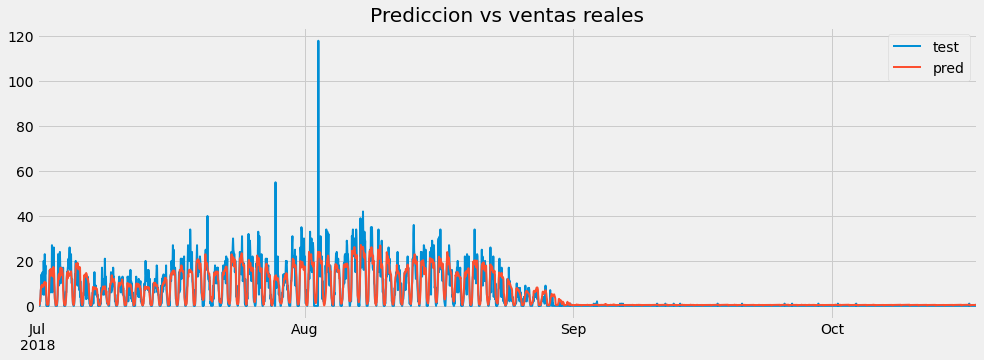

In [33]:
# Gráfico
# ============================================================================
fig, ax = plt.subplots(figsize=(15,5))
datos.loc[predicciones.index, 'cantidad_ventas'].plot(ax=ax, linewidth=2, label='test')
predicciones.plot(linewidth=2,label='prediccion', ax=ax)
ax.set_title('Prediccion vs ventas reales')
ax.legend();

Ahora con el modelo ya entrenado, hago la predicción sobre los ultimos meses del 2018 a partir de septiembre

In [34]:
datos.tail(10)

,cantidad_ventas,dia_semana_0,dia_semana_1,dia_semana_2,dia_semana_3,dia_semana_4,dia_semana_5,dia_semana_6,holidays,dia_semana
order_purchase_timestamp,,,,,,,,,,
2018-10-17 09:00:00,0,0,0,1,0,0,0,0,0,3
2018-10-17 10:00:00,0,0,0,1,0,0,0,0,0,3
2018-10-17 11:00:00,0,0,0,1,0,0,0,0,0,3
2018-10-17 12:00:00,0,0,0,1,0,0,0,0,0,3
2018-10-17 13:00:00,0,0,0,1,0,0,0,0,0,3
2018-10-17 14:00:00,0,0,0,1,0,0,0,0,0,3
2018-10-17 15:00:00,0,0,0,1,0,0,0,0,0,3
2018-10-17 16:00:00,0,0,0,1,0,0,0,0,0,3
2018-10-17 17:00:00,0,0,0,1,0,0,0,0,0,3


In [35]:
# Predicción
# ============================================================================

#Primero creo el dataframe con el que hago la predicción
start = datetime.datetime.strptime("17-10-2018", "%d-%m-%Y")
end = datetime.datetime.strptime("03-01-2019", "%d-%m-%Y")
date_generated = pd.date_range(start, end)

df_predict = pd.DataFrame()
df_predict['order_purchase_timestamp'] = date_generated
df_predict = df_predict.set_index('order_purchase_timestamp')
# Armo el dataframe en intervalos de a 1 hora
df_predict = df_predict.resample(rule='H', closed='left', label='right').sum()

# Agrego columna vacaciones para los dias festivos inamobibles: https://www.datosmundial.com/america/brasil/dias-festivos.php
df_predict['holidays']=  np.where((df_predict.reset_index()['order_purchase_timestamp'].dt.month==1)&(df_predict.reset_index()['order_purchase_timestamp'].dt.day==20),1,
                    np.where((df_predict.reset_index()['order_purchase_timestamp'].dt.month==1)&(df_predict.reset_index()['order_purchase_timestamp'].dt.day==1),1,
                    np.where((df_predict.reset_index()['order_purchase_timestamp'].dt.month==1)&(df_predict.reset_index()['order_purchase_timestamp'].dt.day==25),1,
                    np.where((df_predict.reset_index()['order_purchase_timestamp'].dt.month==4)&(df_predict.reset_index()['order_purchase_timestamp'].dt.day==21),1,
                    np.where((df_predict.reset_index()['order_purchase_timestamp'].dt.month==4)&(df_predict.reset_index()['order_purchase_timestamp'].dt.day==23),1,
                    np.where((df_predict.reset_index()['order_purchase_timestamp'].dt.month==5)&(df_predict.reset_index()['order_purchase_timestamp'].dt.day==1),1,
                    np.where((df_predict.reset_index()['order_purchase_timestamp'].dt.month==6)&(df_predict.reset_index()['order_purchase_timestamp'].dt.day==12),1,
                    np.where((df_predict.reset_index()['order_purchase_timestamp'].dt.month==7)&(df_predict.reset_index()['order_purchase_timestamp'].dt.day==9),1,
                    np.where((df_predict.reset_index()['order_purchase_timestamp'].dt.month==8)&(df_predict.reset_index()['order_purchase_timestamp'].dt.day==15),1,
                    np.where((df_predict.reset_index()['order_purchase_timestamp'].dt.month==8)&(df_predict.reset_index()['order_purchase_timestamp'].dt.day==28),1,
                    np.where((df_predict.reset_index()['order_purchase_timestamp'].dt.month==9)&(df_predict.reset_index()['order_purchase_timestamp'].dt.day==7),1,
                    np.where((df_predict.reset_index()['order_purchase_timestamp'].dt.month==10)&(df_predict.reset_index()['order_purchase_timestamp'].dt.day==12),1,
                    np.where((df_predict.reset_index()['order_purchase_timestamp'].dt.month==10)&(df_predict.reset_index()['order_purchase_timestamp'].dt.day==15),1,
                    np.where((df_predict.reset_index()['order_purchase_timestamp'].dt.month==10)&(df_predict.reset_index()['order_purchase_timestamp'].dt.day==28),1,
                    np.where((df_predict.reset_index()['order_purchase_timestamp'].dt.month==11)&(df_predict.reset_index()['order_purchase_timestamp'].dt.day==2),1,
                    np.where((df_predict.reset_index()['order_purchase_timestamp'].dt.month==11)&(df_predict.reset_index()['order_purchase_timestamp'].dt.day==15),1,
                    np.where((df_predict.reset_index()['order_purchase_timestamp'].dt.month==11)&(df_predict.reset_index()['order_purchase_timestamp'].dt.day==20),1,
                    np.where((df_predict.reset_index()['order_purchase_timestamp'].dt.month==12)&(df_predict.reset_index()['order_purchase_timestamp'].dt.day==24),1,
                    np.where((df_predict.reset_index()['order_purchase_timestamp'].dt.month==12)&(df_predict.reset_index()['order_purchase_timestamp'].dt.day==25),1,
                    np.where((df_predict.reset_index()['order_purchase_timestamp'].dt.month==12)&(df_predict.reset_index()['order_purchase_timestamp'].dt.day==26),1,
                    np.where((df_predict.reset_index()['order_purchase_timestamp'].dt.month==12)&(df_predict.reset_index()['order_purchase_timestamp'].dt.day==31),1,
                    0)))))))))))))))))))))

# Creo variable que indica si es fin de semana
df_predict['dia_semana'] = df_predict.index.dayofweek
df_predict = pd.get_dummies(df_predict, columns=['dia_semana'])
df_predict = df_predict.fillna(0)

# Creo una ventana de las ultima 48hs para empezar a predecir en septiembre
datos_ultimas_48hs = datos.loc['2018-10-15 18:00:00':'2018-10-17 18:00:00', 'cantidad_ventas']
exog_siguiente_mes = df_predict[variables_exog][:1848]

predicciones = forecaster.predict(steps=1848, exog=exog_siguiente_mes, last_window=datos_ultimas_48hs)
predicciones

2018-10-17 19:00:00    0.291768
2018-10-17 20:00:00    0.390243
2018-10-17 21:00:00    0.401054
2018-10-17 22:00:00    0.381353
2018-10-17 23:00:00    0.381353
                         ...   
2019-01-02 14:00:00    0.643487
2019-01-02 15:00:00    0.643487
2019-01-02 16:00:00    0.643487
2019-01-02 17:00:00    0.643487
2019-01-02 18:00:00    0.590277
Freq: H, Name: pred, Length: 1848, dtype: float64

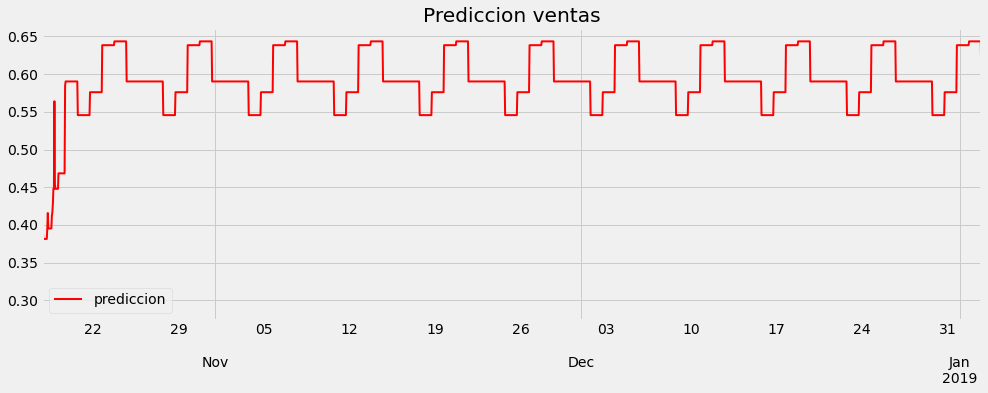

In [38]:
# Gráfico
# ============================================================================
fig, ax = plt.subplots(figsize=(15,5))
predicciones.plot(linewidth=2,label='prediccion', color='red',ax=ax)
ax.set_title('Prediccion ventas')
ax.legend();

In [39]:
# Plot de predicciones interactivas
# ============================================================================
datos_plot=pd.DataFrame({
                'histórico': datos['cantidad_ventas'],
                'predicción': predicciones,
})
datos_plot.index.name='order_purchase_timestamp'

fig = px.line(
    data_frame  = datos_plot.reset_index(),
    x           = 'order_purchase_timestamp',
    y           = datos_plot.columns,
    title       = 'Ventas totales',
    width       = 1200,
    height      = 500
)

fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [ ]:
predicciones.to_csv('predicciones')